In [1]:
%pip install cudaq
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.3/123.3 MB 63.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.1/401.1 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.0/202.0 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 74.4 MB/s eta 0:00:00:00:0100:01
  Created wheel for cudaq: filename=cudaq-0.13.0-py3-none-any.whl size=7004 sha256=f5d1ec9d0d8aef09581cddbc4dd72091872149b1211a1887ecd47797ffe1d4ba
  Stored in directory: /home/cudaq/.cache/pip/wheels/fb/8a/10/ee10abd8723a2fbfd7962112962900ec48cbba4de11305846d
Successfully built cudaq
Note: you may need to restart the kernel to use 

In [2]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cudaq
import numpy as np
from typing import List, Tuple, Set, Dict
from dataclasses import dataclass
from collections import deque
import warnings

# ============================================================================
# 1. LABS PROBLEM PHYSICS
# ============================================================================

def compute_labs_energy(sequence: np.ndarray) -> int:
    """
    Compute LABS energy E(s) = sum_k C_k^2
    Where C_k is the aperiodic autocorrelation at lag k.
    """
    n = len(sequence)
    energy = 0
    for k in range(1, n):
        c_k = np.sum(sequence[:-k] * sequence[k:])
        energy += c_k * c_k
    return int(energy)

def bitstring_to_spins(bitstring: str) -> np.ndarray:
    """Convert measurement bitstring ('0'/'1') to spin array (+1/-1)."""
    # CUDA-Q returns bitstrings; standard mapping |0> -> +1, |1> -> -1
    return np.array([1 if b == '0' else -1 for b in bitstring])

def spins_to_bitstring(spins: np.ndarray) -> str:
    """Convert spin array (+1/-1) to bitstring key."""
    return ''.join('0' if s == 1 else '1' for s in spins)

In [4]:
# ============================================================================
# 2. CUDA-Q KERNEL (QAOA)
# ============================================================================

@cudaq.kernel
def labs_qaoa(n_qubits: int, p: int, gammas: List[float], betas: List[float]):
    """
    CUDA-Q Kernel for LABS QAOA.
    Includes manual decomposition of Rzz gates for CUDA-Q compatibility.
    """
    # Allocate qubits
    q = cudaq.qvector(n_qubits)

    # 1. Initialization (Hadamard on all)
    h(q)

    # 2. QAOA Layers
    for layer in range(p):
        gamma = gammas[layer]
        beta = betas[layer]

        # --- Problem Unitary (Cost Hamiltonian) ---

        # A. 2-body terms (ZZ)
        # Decomposed Rzz(theta) -> CNOT, Rz(theta), CNOT
        for i in range(n_qubits - 1):
            for k in range(1, (n_qubits - i) // 2 + 1):
                j = i + k
                if j < n_qubits:
                    # We want exp(-i * gamma * Z * Z)
                    # This is Rzz(2*gamma).
                    # Decomposition:
                    cx(q[i], q[j])
                    rz(2.0 * gamma, q[j])
                    cx(q[i], q[j])

        # B. 4-body terms (ZZZZ)
        # Decomposed into CNOT ladder + Rz
        for i in range(n_qubits - 3):
            max_t = (n_qubits - i - 1) // 2
            for t in range(1, max_t + 1):
                for k in range(t + 1, n_qubits - i - t):
                    idx1, idx2 = i, i+t
                    idx3, idx4 = i+k, i+k+t

                    if idx4 < n_qubits:
                        # Compute parity of 4 qubits into idx4
                        # Using cx() is cleaner than x.ctrl()
                        cx(q[idx1], q[idx2])
                        cx(q[idx3], q[idx4])
                        cx(q[idx2], q[idx4]) # Parity is now on idx4

                        # Apply Rotation (Rz) on the parity qubit
                        # Rz(theta) = exp(-i * theta/2 * Z)
                        # We want exp(-i * gamma * Z...Z), so theta = 2*gamma
                        rz(2.0 * gamma, q[idx4])

                        # Uncompute Parity (Reverse the CNOTs)
                        cx(q[idx2], q[idx4])
                        cx(q[idx3], q[idx4])
                        cx(q[idx1], q[idx2])

        # --- Mixer Unitary (Rx rotations) ---
        rx(2.0 * beta, q)

    # Measurement (Measure all qubits in Z basis)
    mz(q)

In [5]:
# ============================================================================
# 3. CLASSICAL OPTIMIZER (Tabu Logic)
# ============================================================================

@dataclass
class MTSConfig:
    """Configuration for Memetic Tabu Search"""
    tabu_tenure: int = 7
    max_iterations: int = 1000
    population_size: int = 10
    crossover_rate: float = 0.8
    mutation_rate: float = 0.1
    elite_size: int = 2

class MemeticTabuSearch:
    def __init__(self, n: int, config: MTSConfig):
        self.n = n
        self.config = config

        # Tabu Structures
        self.tabu_set: Set[str] = set()
        self.tabu_queue: deque = deque()

        self.best_solution: np.ndarray = None
        self.best_energy: int = float('inf')

    def _update_tabu(self, bitstring_key: str):
        self.tabu_set.add(bitstring_key)
        self.tabu_queue.append(bitstring_key)
        limit = self.config.tabu_tenure * self.n
        if len(self.tabu_queue) > limit:
            removed = self.tabu_queue.popleft()
            if removed in self.tabu_set:
                self.tabu_set.remove(removed)

    def local_search(self, sequence: np.ndarray) -> Tuple[np.ndarray, int]:
        current = sequence.copy()
        current_energy = compute_labs_energy(current)
        improved = True

        while improved:
            improved = False
            best_neighbor = None
            best_neighbor_energy = current_energy
            best_neighbor_key = ""

            for i in range(self.n):
                neighbor = current.copy()
                neighbor[i] *= -1
                key = spins_to_bitstring(neighbor)

                if key in self.tabu_set: continue

                en = compute_labs_energy(neighbor)
                if en < best_neighbor_energy:
                    best_neighbor = neighbor
                    best_neighbor_energy = en
                    best_neighbor_key = key

            if best_neighbor is not None:
                current = best_neighbor
                current_energy = best_neighbor_energy
                improved = True
                self._update_tabu(best_neighbor_key)

        return current, current_energy

    def crossover(self, p1, p2):
        if np.random.random() > self.config.crossover_rate: return p1.copy()
        pts = sorted(np.random.choice(self.n, 2, replace=False))
        child = p1.copy()
        child[pts[0]:pts[1]] = p2[pts[0]:pts[1]]
        return child

    def mutate(self, seq):
        res = seq.copy()
        for i in range(self.n):
            if np.random.random() < self.config.mutation_rate: res[i] *= -1
        return res

    def evolve_population(self, population):
        evaluated = [(s, compute_labs_energy(s)) for s in population]
        evaluated.sort(key=lambda x: x[1])

        if evaluated[0][1] < self.best_energy:
            self.best_energy = evaluated[0][1]
            self.best_solution = evaluated[0][0].copy()

        new_pop = [s.copy() for s, _ in evaluated[:self.config.elite_size]]

        while len(new_pop) < self.config.population_size:
            idx = np.random.choice(len(population), 2, replace=False)
            child = self.crossover(population[idx[0]], population[idx[1]])
            child = self.mutate(child)
            child, e = self.local_search(child)
            new_pop.append(child)
            if e < self.best_energy:
                self.best_energy = e
                self.best_solution = child.copy()

        return new_pop

    def optimize(self, initial_pop):
        population = initial_pop
        # Initial Local Search Pass
        for i in range(len(population)):
            population[i], e = self.local_search(population[i])
            if e < self.best_energy:
                self.best_energy = e
                self.best_solution = population[i].copy()

        for _ in range(self.config.max_iterations):
            population = self.evolve_population(population)
            if self.best_energy <= 2 and self.n <= 6: break

        return self.best_solution, self.best_energy

In [6]:
class QuantumEnhancedMTS_CUDA:
    def __init__(self, n: int, qaoa_layers: int = 2, shots: int = 1024):
        self.n = n
        self.qaoa_layers = qaoa_layers
        self.shots = shots
        # cudaq automatically selects the best target (GPU if available)
        print(f"CUDA-Q Target: {cudaq.get_target().name}")

    def generate_quantum_candidates(self, gamma_vals, beta_vals, num_candidates=10):
        # 1. Run the kernel on the simulation target
        # Note: We pass the lists directly to the kernel
        result = cudaq.sample(
            labs_qaoa,
            self.n,
            self.qaoa_layers,
            gamma_vals,
            beta_vals,
            shots_count=self.shots
        )

        # 2. Process results
        # result.items() returns list of (bitstring, count)
        # Sort by count descending
        sorted_samples = sorted(result.items(), key=lambda x: -x[1])

        candidates = []
        for bs, count in sorted_samples:
            # Check bitstring length (sometimes leading zeros are dropped in some backends)
            # cudaq bitstrings usually match qubit count, but good to be safe.
            padded_bs = bs.zfill(self.n)
            candidates.append(bitstring_to_spins(padded_bs))
            if len(candidates) >= num_candidates:
                break

        # Fallback if low entropy
        while len(candidates) < num_candidates:
            candidates.append(np.random.choice([1, -1], size=self.n))

        return candidates

    def optimize(self, gamma=None, beta=None, mts_config=None):
        if mts_config is None: mts_config = MTSConfig()
        if gamma is None: gamma = [0.1] * self.qaoa_layers
        if beta is None: beta = [0.1] * self.qaoa_layers

        print(f"1. CUDA-Q QAOA Sampling ({self.shots} shots)...")
        candidates = self.generate_quantum_candidates(gamma, beta, mts_config.population_size)

        best_q_energy = min([compute_labs_energy(c) for c in candidates])
        print(f"   -> Best candidate energy from Quantum: {best_q_energy}")

        print("2. Starting Classical Memetic Tabu Search...")
        mts = MemeticTabuSearch(self.n, mts_config)
        best_seq, best_en = mts.optimize(candidates)

        return best_seq, best_en

In [7]:
# Control run
N_PROBLEM = 7

qe_mts_cuda = QuantumEnhancedMTS_CUDA(
    n=N_PROBLEM,
    qaoa_layers=2,
    shots=2048
)

mts_config = MTSConfig(
    tabu_tenure=3,
    max_iterations=50,
    population_size=10,
    elite_size=2
)

# Run Optimization
best_sequence, best_energy = qe_mts_cuda.optimize(
    gamma=[0.5, 0.5],
    beta=[0.5, 0.5],
    mts_config=mts_config
)

print("\n================ CUDA-Q RESULT ================")
print(f"Best Sequence Found: {best_sequence}")
print(f"Best Energy: {best_energy}")
print(f"Bitstring: {spins_to_bitstring(best_sequence)}")

CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (2048 shots)...
   -> Best candidate energy from Quantum: 7
2. Starting Classical Memetic Tabu Search...

================ CUDA-Q RESULT ================
Best Sequence Found: [ 1 -1  1  1 -1 -1 -1]
Best Energy: 3
Bitstring: 0100111


N     | Energy     | Time (s)   | Sequence
-------------------------------------------------------
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 1
2. Starting Classical Memetic Tabu Search...
3     | 1          | 0.0042     | 100
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 2
2. Starting Classical Memetic Tabu Search...
4     | 2          | 0.0026     | 1011
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 6
2. Starting Classical Memetic Tabu Search...
5     | 2          | 0.0038     | 00010
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 7
2. Starting Classical Memetic Tabu Search...
6     | 7          | 0.0330     | 010001
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 7
2. Starting Classical Memetic Tab

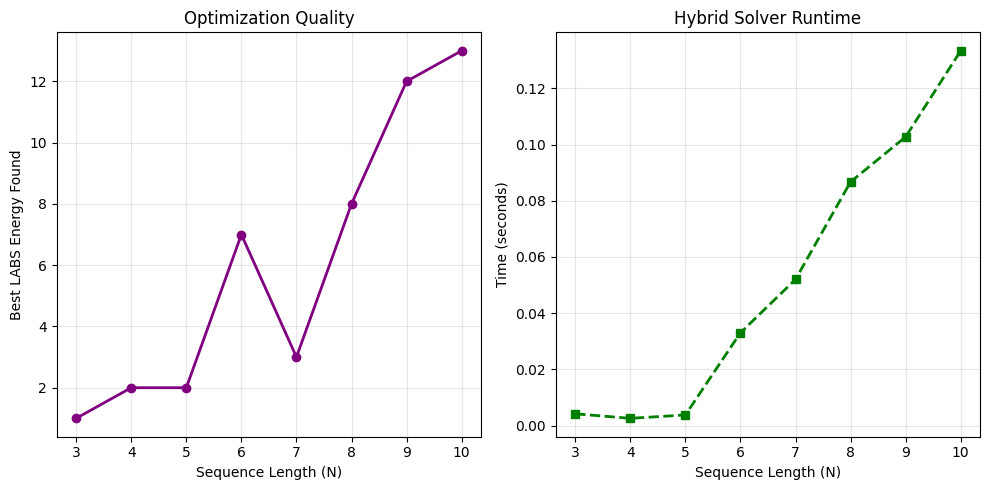

In [8]:
import time
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================================
# CONFIGURATION
# ============================================================================
test_results = []
problem_sizes = range(3, 11)

sweep_config = MTSConfig(
    tabu_tenure=5,
    max_iterations=30,  # Enough to find optima for small N
    population_size=10,
    elite_size=2
)

print(f"{'N':<5} | {'Energy':<10} | {'Time (s)':<10} | {'Sequence'}")
print("-" * 55)

# ============================================================================
# EXECUTION LOOP
# ============================================================================
for n in problem_sizes:
    start_time = time.time()

    # 1. Instantiate Orchestrator for current N
    qe_mts_cuda = QuantumEnhancedMTS_CUDA(n=n, qaoa_layers=2, shots=1024)

    # 2. Run Optimization
    best_seq, best_energy = qe_mts_cuda.optimize(
        gamma=[0.6, 0.6],
        beta=[0.4, 0.4],
        mts_config=sweep_config
    )

    elapsed = time.time() - start_time

    # 3. Store Data
    row = {
        'N': n,
        'Best_Energy': best_energy,
        'Time_Seconds': elapsed,
        'Sequence': spins_to_bitstring(best_seq)
    }
    test_results.append(row)

    # 4. Live Print
    print(f"{n:<5} | {best_energy:<10} | {elapsed:.4f}     | {row['Sequence']}")

# ============================================================================
# PLOTTING
# ============================================================================
df = pd.DataFrame(test_results)

plt.figure(figsize=(10, 5))

# Plot 1: Energy vs Problem Size
plt.subplot(1, 2, 1)
plt.plot(df['N'], df['Best_Energy'], 'o-', color='purple', linewidth=2)
plt.title('Optimization Quality')
plt.xlabel('Sequence Length (N)')
plt.ylabel('Best LABS Energy Found')
plt.grid(True, alpha=0.3)

# Plot 2: Runtime Scaling
plt.subplot(1, 2, 2)
plt.plot(df['N'], df['Time_Seconds'], 's--', color='green', linewidth=2)
plt.title('Hybrid Solver Runtime')
plt.xlabel('Sequence Length (N)')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# 1. Save DataFrame
df = pd.DataFrame(test_results)

# 2. Save to CSV
csv_filename = 'cpu_results_H200.csv'
df.to_csv(csv_filename, index=False)

print(f"Results saved to '{csv_filename}'")
print(f"You can now download this file to compare with other benchmarks.")

Results saved to 'cpu_results_H200.csv'
You can now download this file to compare with other benchmarks.


N     | Energy     | Time (s)   | Sequence
-------------------------------------------------------
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 82
2. Starting Classical Memetic Tabu Search...
20    | 26         | 1.0586     | 01100011010001011111
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 86
2. Starting Classical Memetic Tabu Search...
21    | 42         | 1.0954     | 000000111001011001010
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 79
2. Starting Classical Memetic Tabu Search...
22    | 39         | 1.2631     | 0001100000001101101010
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -> Best candidate energy from Quantum: 123
2. Starting Classical Memetic Tabu Search...
23    | 47         | 1.4697     | 11000111111010100100100
CUDA-Q Target: nvidia
1. CUDA-Q QAOA Sampling (1024 shots)...
   -

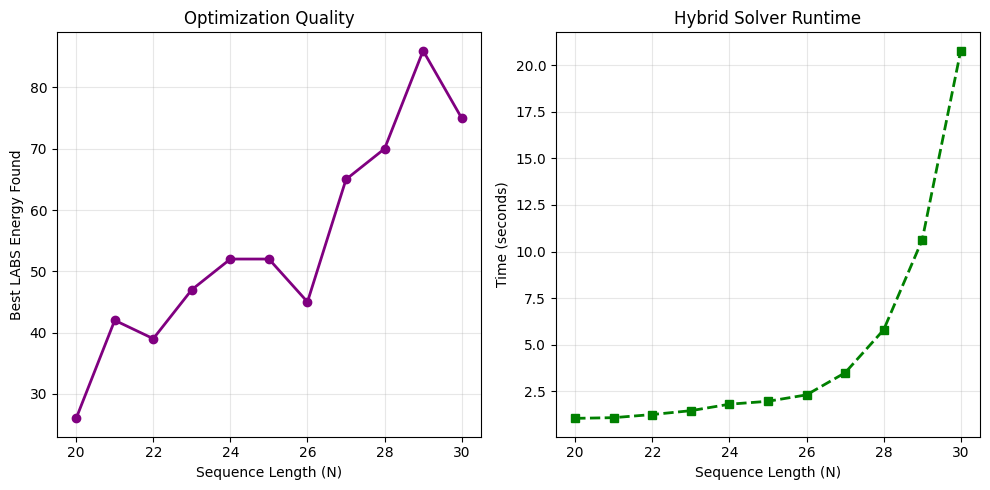

In [10]:
test_results = []
problem_sizes = range(20, 31)

sweep_config = MTSConfig(
    tabu_tenure=5,
    max_iterations=30,  # Enough to find optima for small N
    population_size=10,
    elite_size=2
)

print(f"{'N':<5} | {'Energy':<10} | {'Time (s)':<10} | {'Sequence'}")
print("-" * 55)

# ============================================================================
# EXECUTION LOOP
# ============================================================================
for n in problem_sizes:
    start_time = time.time()

    # 1. Instantiate Orchestrator for current N
    qe_mts_cuda = QuantumEnhancedMTS_CUDA(n=n, qaoa_layers=2, shots=1024)

    # 2. Run Optimization
    best_seq, best_energy = qe_mts_cuda.optimize(
        gamma=[0.6, 0.6],
        beta=[0.4, 0.4],
        mts_config=sweep_config
    )

    elapsed = time.time() - start_time

    # 3. Store Data
    row = {
        'N': n,
        'Best_Energy': best_energy,
        'Time_Seconds': elapsed,
        'Sequence': spins_to_bitstring(best_seq)
    }
    test_results.append(row)

    # 4. Live Print
    print(f"{n:<5} | {best_energy:<10} | {elapsed:.4f}     | {row['Sequence']}")

# ============================================================================
# PLOTTING
# ============================================================================
df = pd.DataFrame(test_results)

plt.figure(figsize=(10, 5))

# Plot 1: Energy vs Problem Size
plt.subplot(1, 2, 1)
plt.plot(df['N'], df['Best_Energy'], 'o-', color='purple', linewidth=2)
plt.title('Optimization Quality')
plt.xlabel('Sequence Length (N)')
plt.ylabel('Best LABS Energy Found')
plt.grid(True, alpha=0.3)

# Plot 2: Runtime Scaling
plt.subplot(1, 2, 2)
plt.plot(df['N'], df['Time_Seconds'], 's--', color='green', linewidth=2)
plt.title('Hybrid Solver Runtime')
plt.xlabel('Sequence Length (N)')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()